# Сессия 3

Импорты

In [128]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Загрузка данных

In [2]:
sample = pd.read_csv("./КЗ Юниоры/Сессия3/sample.csv")

In [71]:
train = pd.read_csv("train.csv", index_col=0)
test =  pd.read_csv("test.csv", index_col=0)
site = pd.read_pickle("КЗ Юниоры/Сессия1/site.pkl")

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier

Разобьем тренировочный датасет на признаки и целевую переменную. Далее разобьем данные на обучающую и отложенную выборки используя `train_test_split`

In [11]:
X = train.drop(["session_id", "target"], axis=1)

In [13]:
y = train.target

In [15]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

У нас есть одна проблема, данный датасет не является сбалансированным, то есть на 200 тыс сессий с таргетом 0 мы имееи всего 3 тыс сессий с таргетом 1. К сожалению скорей всего создать синтетические образы не выйдет, так как на целевую влияют как затраченое нанее время, так и сайты посещенные пользователем. Поэтому для улучшения работы я буду во-первых использовать сбалансированные веса для моделей, а во-вторых будем использовать метрики f1_score и cohen_kappa_score, которые лучше справляются с несбалансированными данными. метрика точности же будет скорей всего показывать точность приблеженную к 100% потому то модель будет считать что в нашем случае проще поставить везде 0 и она угадает.

In [79]:
train.target.value_counts()

0    228794
1      2258
Name: target, dtype: int64

модели: логистическая регрессия, которая также подходит для классификации, также классификатор К-ближайших соседей, и случайный лес

In [93]:
models = [LogisticRegression(class_weight="balanced"),
          KNeighborsClassifier(weights="distance"), 
          RandomForestClassifier(random_state=42, class_weight="balanced"), 
          ]

In [94]:
TestModels = pd.DataFrame()
temp = {}
for model in models:
    m = str(model)
    print(m)
    temp['Model'] = m[:m.index('(')]
    
    clf = model.fit(X_train,y_train)
    pred = clf.predict(X_val)
    
    temp['accuracy_score'] = accuracy_score(pred, y_val)
    print('accuracy_score', accuracy_score(pred, y_val))
    temp["kappa"] = cohen_kappa_score(pred, y_val)
    print('kappa', cohen_kappa_score(pred, y_val))
    temp["f1"] = f1_score(pred, y_val)
    print('f1', f1_score(pred, y_val))

    TestModels = TestModels.append([temp])
TestModels.set_index('Model', inplace=True)

LogisticRegression(class_weight='balanced')
accuracy_score 0.39635137970832024
kappa 0.005497125643768586
f1 0.024624382801076525
KNeighborsClassifier(weights='distance')
accuracy_score 0.9896784177945651
kappa 0.013716186591260393
f1 0.015018773466833543
RandomForestClassifier(class_weight='balanced', random_state=42)
accuracy_score 0.9905702444654286
kappa 0.0808652257861121
f1 0.08173690932311621


Из графика видно что наша подходящая метрика это скорей всего F1_score и лучше всего показал себя случайный лес, так что будем с этой моделью и работать 

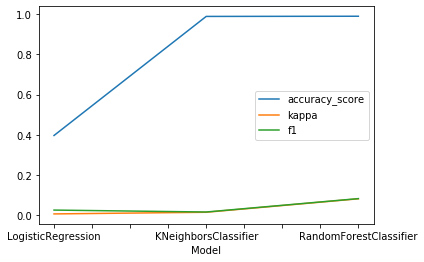

In [95]:
TestModels.plot()

In [29]:
rfc = models[2]

In [59]:
Id = test.session_id

In [61]:
sample = pd.DataFrame({"session_id":Id, "target":tar})

In [70]:
sample

,session_id,target
0,1,0.04
1,2,0.00
2,3,0.00
3,4,0.00
4,5,0.00
...,...,...
74801,82792,0.03
74802,82794,0.00
74803,82795,0.00
74804,82796,0.00


In [102]:
RFC = RandomForestClassifier(random_state=42)

In [136]:
params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9, 10,11,15],
    'criterion' :['gini', 'entropy']
}

In [137]:
def paramsearch(model):
    clf = model
    clf = clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    # print('accuracy_score', accuracy_score(pred, ytest))
    return accuracy_score(pred, y_val), f1_score(pred, y_val), cohen_kappa_score(pred, y_val)

In [138]:
rfdf = pd.DataFrame()
tmp = {}
for n in params["n_estimators"]:
    for mf in params["max_features"]:
        for md in params["max_depth"]:
            for c in params["criterion"]:
                tmp["n_estimators"] = n
                tmp["max_features"] = mf
                tmp["max_depth"] = md
                tmp["criterion"] = c

                RFC.n_estimators = n
                RFC.max_features = mf
                RFC.max_depth = md
                RFC.criterion = c

                ac, f, kappa = paramsearch(RFC)
                tmp["acc"] = ac
                tmp["f1"] = f
                tmp["kappa"] = kappa
                rfdf = rfdf.append([tmp])
                print("d", end="")


dddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd

График зависимости гиперпараметра max_depth от метрики

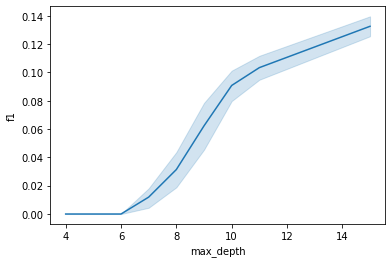

In [139]:
sns.lineplot(data=rfdf, x="max_depth", y="f1")

In [145]:
rfdf[rfdf.f1 == rfdf.f1.max()]

,n_estimators,max_features,max_depth,criterion,acc,f1,kappa
0,200,auto,15,gini,0.990911,0.145499,0.144138
0,200,sqrt,15,gini,0.990911,0.145499,0.144138
0,200,log2,15,gini,0.990911,0.145499,0.144138
0,500,auto,15,gini,0.990911,0.145499,0.144138
0,500,sqrt,15,gini,0.990911,0.145499,0.144138
0,500,log2,15,gini,0.990911,0.145499,0.144138


In [140]:
RFC = RandomForestClassifier(random_state=42,n_estimators=500, max_features="auto", max_depth=15, criterion="gini", bootstrap=False)

In [141]:
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=15, n_estimators=500,
                       random_state=42)

In [142]:
pr = RFC.predict_proba(test.drop(["session_id"], axis=1))

In [143]:
tar = []
for i in pr:
    tar.append(i[1])
    
Id = test.session_id

sample = pd.DataFrame({"session_id":Id, "target":tar})

прогноз предсказанных вероятностей

In [144]:
sample

,session_id,target
0,1,0.005070
1,2,0.000000
2,3,0.000146
3,4,0.003233
4,5,0.002998
...,...,...
74801,82792,0.022158
74802,82794,0.000408
74803,82795,0.010993
74804,82796,0.009996
